In [1]:
from src.partition import Partition
from src.generators import PartitionClass
from src.visualization import Visualizer
import numpy as np
import os

import plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense, Conv2D, Flatten,
    ConvLSTM2D, BatchNormalization, Reshape,
    Conv3D, Input, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose
)
from keras.utils import plot_model
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

Using TensorFlow backend.


In [2]:
# Adapted: https://www.kaggle.com/vincentman0403/vae-with-convolution-on-mnist
n = 20

In [3]:
training_partitions = [Partition()] + [p for p in PartitionClass(n).grid_group()]
training_matrices = [p.fit_matrix(n) for p in training_partitions]
training_targets = [p.fit_matrix(n) for p in training_partitions]

X = np.array(training_matrices).reshape(-1, n, n, 1)
y = np.array(training_targets).reshape(-1, n, n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# VAE


In [5]:
# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,1)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [6]:
input_shape = (n, n, 1)
batch_size = 32
kernel_size = 3
filters = 32
latent_dim = 3
epochs = 10000
use_mse = False
load_weights = False

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 128)  73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12800)        0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 12800)             51200     
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 20, 20, 32)        36896     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 40, 40, 16)        4624      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 40, 40, 1)         145       
Total params: 92,865
Trainable params: 92,865
Non-trainable params: 0
_______________________________________________________

In [14]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [15]:
if use_mse:
    reconstruction_loss = keras.losses.mse
else:
    reconstruction_loss = keras.losses.binary_crossentropy

    
xent_loss = (n * n) * reconstruction_loss(K.flatten(inputs), K.flatten(outputs))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + (kl_loss))

# reconstruction_loss *= n * n
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [16]:
vae.compile(optimizer='rmsprop')
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
es = EarlyStopping(monitor='val_loss', min_delta=.001, patience=1000, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
cbs = [es, lr]

vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 40, 40, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 279414    
_________________________________________________________________
decoder (Model)              (None, 40, 40, 1)         92865     
Total params: 372,279
Trainable params: 372,279
Non-trainable params: 0
_________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning:

Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.



In [17]:
vae.fit(X_train,
        epochs=epochs,
        batch_size=100,
        validation_data=(X_test, None),
        callbacks = cbs[:1])

Train on 161481 samples, validate on 53827 samples
Epoch 1/10000
161481/161481 [==============================] - 258s 2ms/step - loss: 26.0732 - val_loss: 17.6058
Epoch 2/10000
161481/161481 [==============================] - 237s 1ms/step - loss: 17.0631 - val_loss: 16.5710
Epoch 3/10000
161481/161481 [==============================] - 237s 1ms/step - loss: 16.3666 - val_loss: 16.2392
Epoch 4/10000
161481/161481 [==============================] - 282s 2ms/step - loss: 16.1202 - val_loss: 16.1285
Epoch 5/10000
161481/161481 [==============================] - 248s 2ms/step - loss: 15.9726 - val_loss: 15.9286
Epoch 6/10000
161481/161481 [==============================] - 254s 2ms/step - loss: 15.8630 - val_loss: 15.8418
Epoch 7/10000
161481/161481 [==============================] - 267s 2ms/step - loss: 15.7901 - val_loss: 15.7212
Epoch 8/10000
161481/161481 [==============================] - 248s 2ms/step - loss: 15.7257 - val_loss: 15.5715
Epoch 9/10000
  3700/161481 [................

KeyboardInterrupt: 

In [18]:
vae.save(f'serialization/models/cnn_vae_{n}_all.h5')

# Validation

In [4]:
visualizer = Visualizer(f'serialization/models/cnn_vae_{n}_all.h5', full_path = True)

In [5]:
# test = sorted([(p, p._next_oblak_step[1]) for p in PartitionClass(n).grid_group()], key = len)

In [6]:
partitions = [p for p in [Partition([])] + [p for p in PartitionClass(n).grid_group()]]

# partitions = [p for p in PartitionClass(n).grid_group() if p.is_stable or p.is_almost_rectangular()]

In [7]:
test = []
for p in partitions:#PartitionClass(n).grid_group():
    reduction_group = [p]
    
    while not p.is_stable:
        p = p._next_oblak_step[1]
        
        reduction_group.append(p)
        
    if reduction_group[-1] != Partition([]):
        reduction_group.append(Partition([]))
        
    test.append(reduction_group)
    
test = sorted(test, key = len)

In [14]:
import pandas as pd

In [6]:
pd.DataFrame([(p, p.num_corners, p.box_size) for p in partitions if p.is_stable])[1].value_counts()

NameError: name 'pd' is not defined

In [9]:
visualizer.model.predict(Partition((15, 8, 1, 1, 1)))

(15, 7, 1, 1, 1)

In [8]:
Partition(0, 0)

(0, 0)

In [15]:
out.reshape(20, 20)[0]

array([9.9997932e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.5467405e-05, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [12]:
visualizer.visualize([p for p in partitions if p.is_stable],
                     color = lambda x: x.num_corners, lines = False)

In [30]:
len([np.random.randint(40) + 1 for x in range(41)])

41

In [130]:
vae_inputs = visualizer._partitions_to_inputs(partitions)

In [97]:
visualizer.encoder.predict(vae_inputs)[0].shape

(2714, 3)

In [37]:
encoder = vae.layers[1]

z_mean, _, _ = encoder.predict(np.concatenate([X_train, X_test]),
                                   batch_size=batch_size)

fig = go.Figure((go.Scatter3d(
    x=z_mean[:, 0],
    y = z_mean[:, 1],
    z = z_mean[:, 2],
    name="z",
    mode='markers',
    text = [repr(p) for p in partitions],
    marker=dict(
        size=10,
        color = colorings,
        colorscale='Viridis',
    )
)))

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

In [38]:
partitions = []
for ptn_matrix in np.concatenate([y_train, y_test]).reshape(-1, n, n):
    parts = []
    for row in ptn_matrix:
        row_sum = sum(row)
        if not row_sum:
            break
        parts.append(int(row_sum))
        
    partitions.append(Partition(parts))
    

colorings = [p.is_stable for p in partitions]

In [63]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    X_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(X_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=colorings, cmap = 'winter')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename, transparent = True)
    plt.show()

    filename = os.path.join(model_name, "partitions_over_latent.png")
    # display a 30x30 2D manifold of digits
    grid = 20
    digit_size = n
    figure = np.zeros((digit_size * grid, digit_size * grid))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    
    if latent_dim == 2:
        grid_x = np.linspace(-4, 4, grid)
        grid_y = np.linspace(-4, 4, grid)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    else:
        grid_x = np.linspace(-4, 4, grid)
        grid_y = np.linspace(-4, 4, grid)[::-1]
        grid_z = np.linspace(-4, 4, grid)[::-1]

        for i, zi in enumerate(grid_z):
            for i, yi in enumerate(grid_y):
                for j, xi in enumerate(grid_x):
                    z_sample = np.array([[xi, yi]])
                    x_decoded = decoder.predict(z_sample)
                    digit = x_decoded[0].reshape(digit_size, digit_size)
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                
                
    scale = 2
    plt.figure(figsize=(grid * scale, grid * scale))
    start_range = digit_size // 2
    end_range = (grid - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, transparent = True)
    plt.show()

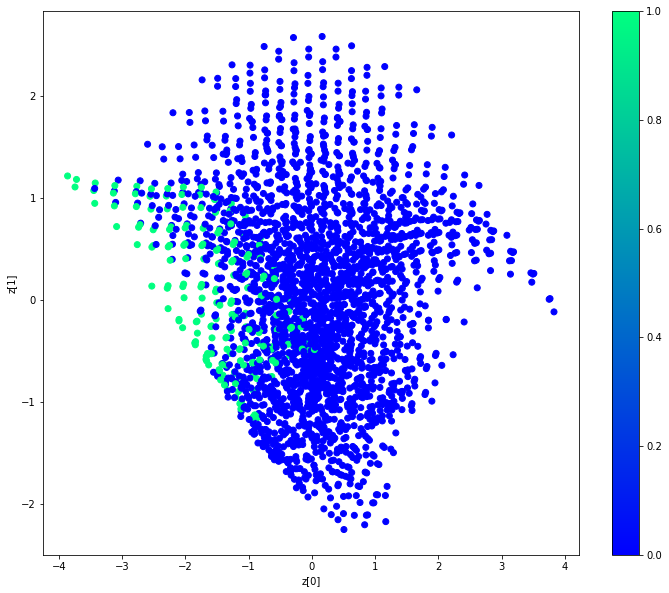

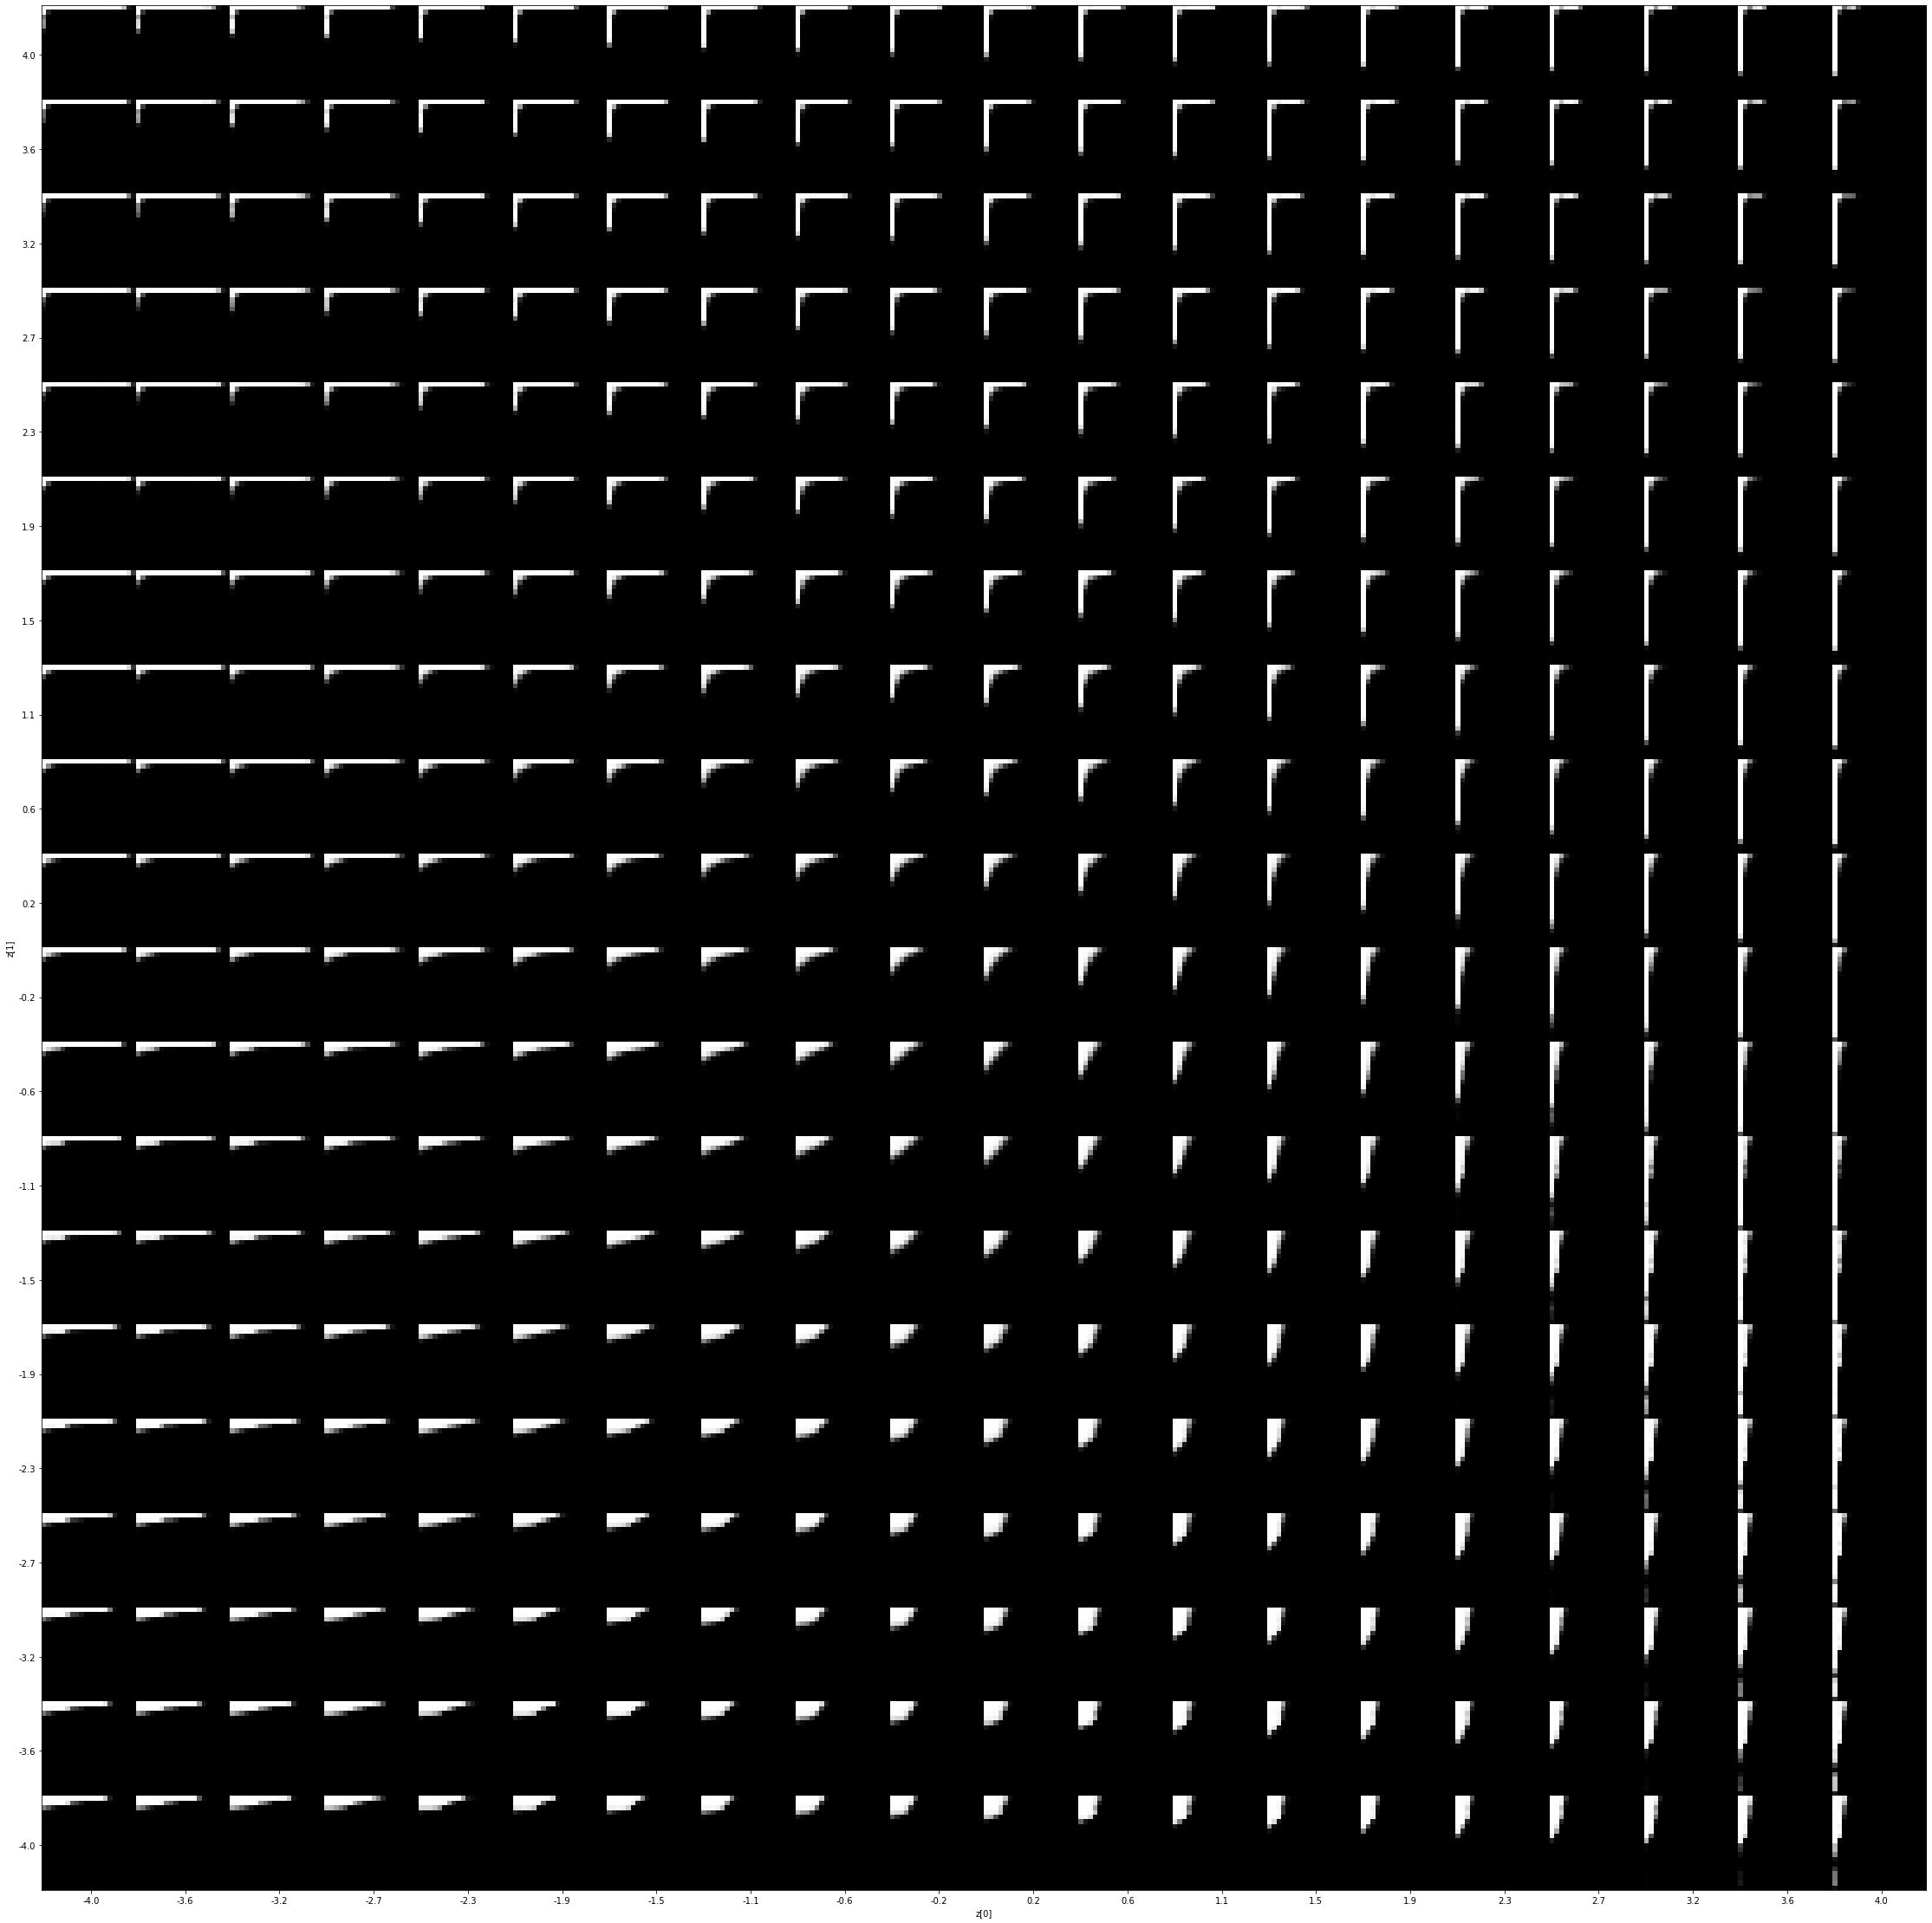

In [64]:
plot_results(vae.layers[1:], (np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])),
             batch_size=batch_size, model_name="vae_mlp")